In [2]:
import random
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

from ann_visualizer.visualize import ann_viz;
from sklearn.tree import export_graphviz
import graphviz

from matplotlib.pyplot import imread
import matplotlib
import numpy as np
import os
import imageio
import cv2
from random import seed
seed(42)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.initializers import he_normal
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, Input, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from numpy.testing import assert_allclose
import nibabel as nib
from nibabel.testing import data_path
from PIL import Image
import nilearn
from nilearn import image, plotting


C:\Users\Tanuja\anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True
)

In [4]:
def get_slice(): 
    path = 'images/'
    disc_list = os.listdir(path)
    MacOS_file = '.DS_Store'
    if MacOS_file in disc_list:
        disc_list.remove(MacOS_file) # remove MacOS file

    brain_list, total_subjects = [], [] # generate list of brain images for input to NN, all subjects used in study
    
    for disc in disc_list:
        path_ind_disc = f'{path}/{disc}'
        subject_list_p_disc = os.listdir(path_ind_disc) # generate list of subjects in each disc
        if MacOS_file in subject_list_p_disc:
            subject_list_p_disc.remove(MacOS_file) # remove MacOS file
            
        for subj_id in subject_list_p_disc:
            total_subjects.append(subj_id) # maintain a list of all subjects included in study for diagnosis labeling later
    
            path_n4 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n3 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n6 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            path_n5 = path_ind_disc + f'/{subj_id}/FSL_SEG/{subj_id}_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'
            
            path_list = [path_n4,path_n3, path_n6,path_n5]
            for i in path_list:
                if os.path.exists(i) == True:
                    brain_list.append(plt.imread(i)) # append if file format exists

    return disc_list, brain_list, total_subjects

In [5]:
disc_list, brain_list, total_subjects = get_slice()
print("Length of total_subjects", len(total_subjects))
print("Length of brain_list", len(brain_list))


Length of total_subjects 436
Length of brain_list 436


In [6]:
def get_diagnosis(total_subjects): # builds a dictionary of subjects and diagnoses
    oasis1 = pd.read_csv('oasis_cross-sectional.csv') # read in summary file
    oasis1['CDR'].fillna(0, inplace=True) # null values are healthy diagnoses
    diagnosis_qual={0.:'normal', 0.5:'AD', 1.:'AD', 2.:'AD' } # convert diagnosis to labels
    oasis1.replace({"CDR": diagnosis_qual}, inplace=True)
    diagnosis_quant={'normal':0,'AD':1} # convert diagnosis to numerical values
    oasis1.replace({"CDR": diagnosis_quant}, inplace=True)
    oasis1['Subject'] =pd.DataFrame([subj[0:9] for subj in oasis1['ID']]) # extract subject ID from MR ID
    
    subjects = [subj[0:9] for subj in total_subjects] # get subject names for each MRI ID
    subjects = pd.DataFrame(subjects, columns = ['Subject']) # convert to dataframe
    
    diagnosis_dict= {oasis1['Subject'][num]: oasis1['CDR'][num] for num in range(0, 436)} # create a dictionary with subject and diagnosis
    diag = [diagnosis_dict[subj] for subj in subjects['Subject']] # create a list of diagnoses to append to dataframe of subjects
    subjects['Diagnosis'] = pd.DataFrame(diag)
    
    print("Length of diag:", len(diag))

    return subjects, diagnosis_dict

In [7]:
subjects, diagnosis_dict = get_diagnosis(total_subjects)
print("Length of subjects['Diagnosis']:", len(subjects['Diagnosis']))
print("Length of diagnosis_dict:", len(diagnosis_dict))

print(subjects)

Length of diag: 436
Length of subjects['Diagnosis']: 436
Length of diagnosis_dict: 416
       Subject  Diagnosis
0    OAS1_0001          0
1    OAS1_0002          0
2    OAS1_0003          1
3    OAS1_0004          0
4    OAS1_0005          0
..         ...        ...
431  OAS1_0343          0
432  OAS1_0344          0
433  OAS1_0345          0
434  OAS1_0346          0
435  OAS1_0348          0

[436 rows x 2 columns]


In [8]:
def balance_set(subjects, total_subjects, disc_list): # balance the data
    AD_subjects = subjects.sort_values(by='Diagnosis', ascending = False).head(97) # all subjects diagnosed as AD
    AD_subjects = AD_subjects.append(AD_subjects)
    head = AD_subjects.head(42) # upsample to balance
    AD_subjects = AD_subjects.append(head)    
    
    for subj in AD_subjects['Subject']:
        total_subjects.append(str(subj) + '_MR1') # maintain a list of all subjects included in study for diagnosis labeling later
    for disc in disc_list:
            path = f'Discs/{disc}'

            for i in AD_subjects['Subject']:

                path_n4 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n3 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n3_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n6 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n6_anon_111_t88_masked_gfc_fseg_tra_90.gif'
                path_n5 = path + f'/{i}_MR1/FSL_SEG/{i}_MR1_mpr_n5_anon_111_t88_masked_gfc_fseg_tra_90.gif'

                path_list = [path_n4,path_n3, path_n6,path_n5]
                for i in path_list:
                    if os.path.exists(i) == True:
                        brain_list.append(plt.imread(i)) # append if file format exists

    brain_array = np.asarray(brain_list)
    return brain_array, AD_subjects

In [9]:
brain_array, AD_subjects = balance_set(subjects, total_subjects, disc_list) 


C:\Users\Tanuja\AppData\Local\Temp/ipykernel_37000/4203462882.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AD_subjects = AD_subjects.append(AD_subjects)
C:\Users\Tanuja\AppData\Local\Temp/ipykernel_37000/4203462882.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AD_subjects = AD_subjects.append(head)


                                                      Test Images                                                       


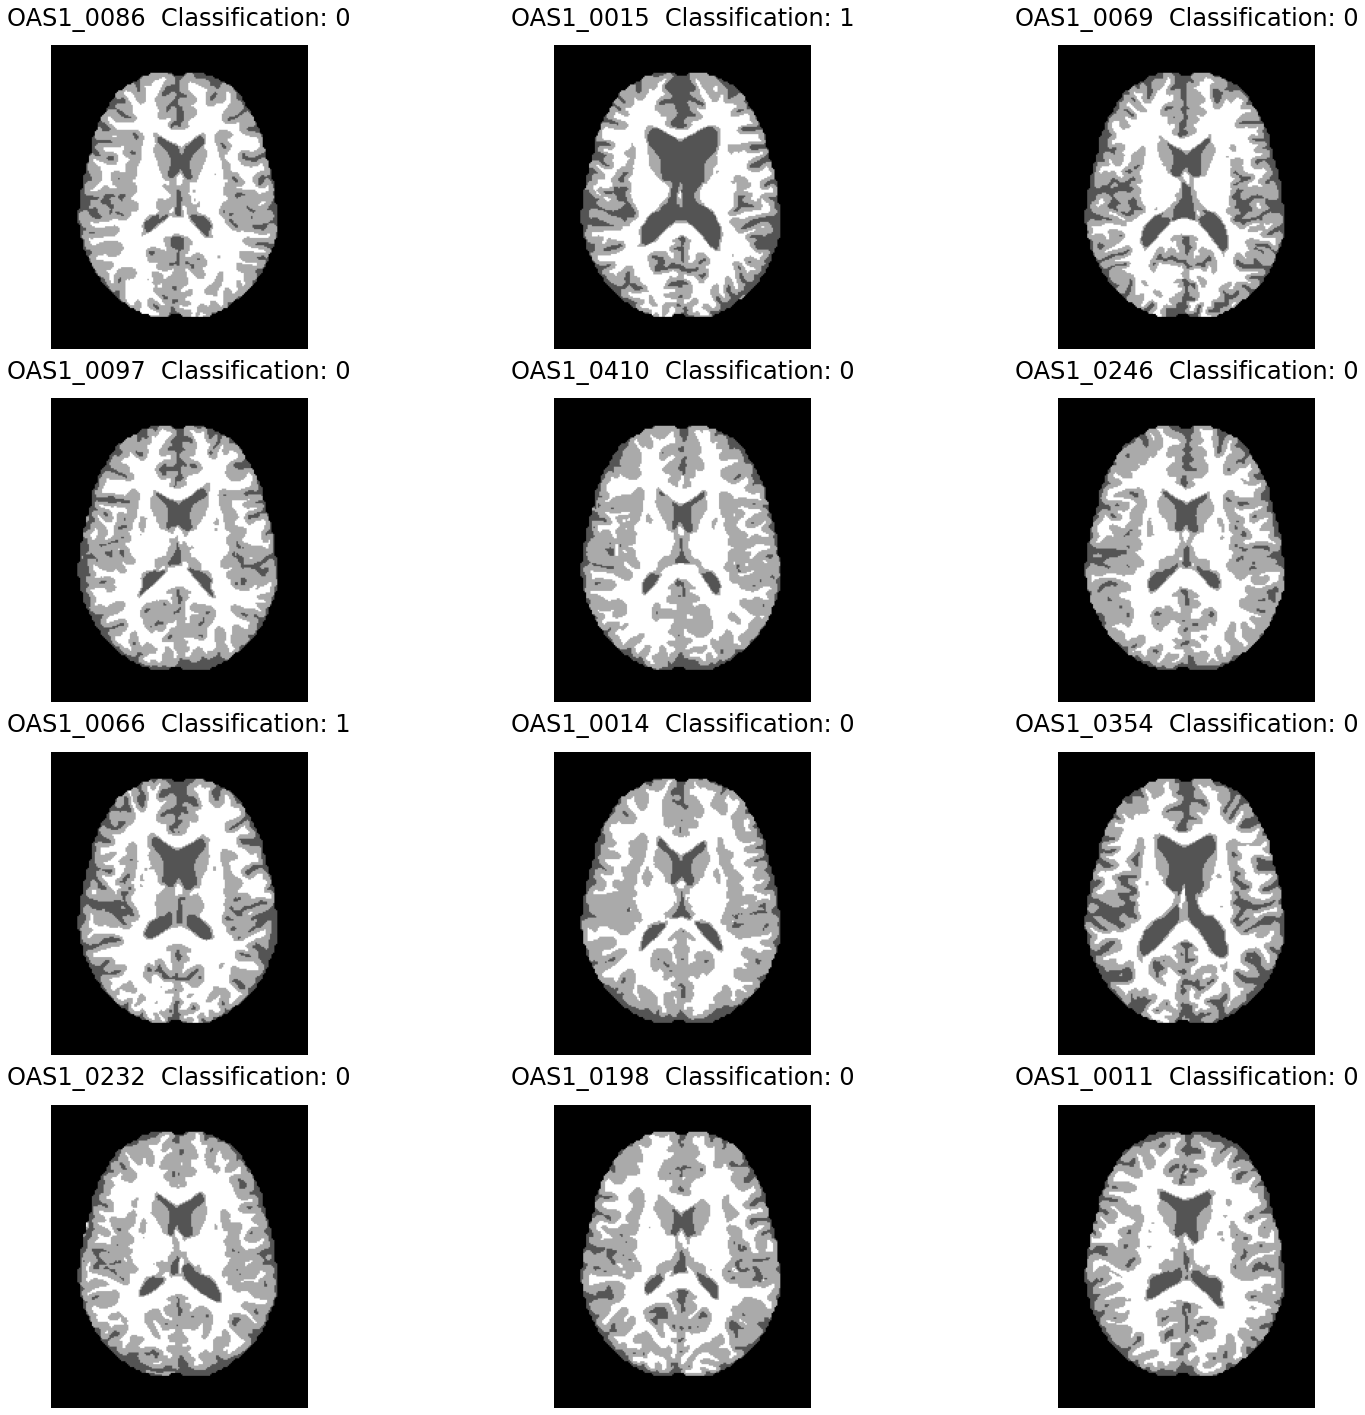

In [10]:
def plot_test_images(subject, diagnosis, array):
    plt.figure(figsize = (20, 20))
    print("Test Images".center(os.get_terminal_size().columns))
    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title(str(subject[i]) +'  Classification: ' + str(diagnosis[i]), fontsize=24, pad = 20)
        plt.tight_layout()
        plt.axis('off')
        plt.imshow(array[i], cmap = 'gray')
        plt.subplots_adjust(wspace = 0.25)
    plt.show()  

shuffled_indices = np.random.permutation(len(subjects))

shuffled_subjects = subjects['Subject'].iloc[shuffled_indices].values
shuffled_diagnosis = subjects['Diagnosis'].iloc[shuffled_indices].values
shuffled_brain_array = brain_array[shuffled_indices]

plot_test_images(shuffled_subjects, shuffled_diagnosis, shuffled_brain_array)


In [12]:
x_MRI = brain_array # array of image values
y_MRI = np.asarray(shuffled_diagnosis) # diagnosis for each subject
x_MRI = x_MRI.reshape(-1, 208, 176,1)

norm = lambda x :(x - np.min(x)) / (np.max(x) - np.min(x)) # normalize x values
x_MRI_norm = norm(x_MRI)
assert (np.min(x_MRI_norm), np.max(x_MRI_norm)) == (0.0, 1.0) # check min and max values
x_MRI_train, x_MRI_temp, y_MRI_train, y_MRI_temp = train_test_split(x_MRI_norm, y_MRI, train_size=0.85, random_state=42)
x_MRI_val, x_MRI_test, y_MRI_val, y_MRI_test = train_test_split(x_MRI_temp, y_MRI_temp, train_size=0.55, random_state=42)
datagen.fit(x_MRI_train)

In [173]:
def get_metrics(model, x_test, y_test): # get accuracy, recall, precision
    results = model.evaluate(x_test, y_test)
    accuracy = round(results[1]*100,2)
    y_pred_prob = model.predict(x_test) # predictions for test set as probabilities
    y_pred = np.where(y_pred_prob > 0.5, 1, 0) # apply threshold to get class labels (assuming binary classification)
    recall = round((recall_score(y_test, y_pred,zero_division=1))*100, 2)
    precision = round(precision_score(y_test, y_pred,zero_division=1)*100, 2)
    return accuracy, recall, precision


In [154]:
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
def build_model(hp):
    
    input_shape = (208,176,1)

    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                     input_shape=(input_shape)))
    model.add(BatchNormalization())
    model.add(Activation(hp.Choice('activation_1', values=['sigmoid', 'relu'])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Int('filters_2', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size_2', values=[3, 5])))
    model.add(BatchNormalization())
    model.add(Activation(hp.Choice('activation_2', values=['sigmoid', 'relu'])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Int('filters_3', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size_3', values=[3, 5])))
    model.add(BatchNormalization())
    model.add(Activation(hp.Choice('activation_3', values=['sigmoid', 'relu'])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=hp.Int('filters_4', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size_4', values=[3, 5])))
    model.add(BatchNormalization())
    model.add(Activation(hp.Choice('activation_4', values=['sigmoid', 'relu'])))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=64, max_value=256, step=32), activation='sigmoid',kernel_regularizer=l1(0.01)))
    
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create a Keras Tuner RandomSearch instance
tuner = RandomSearch(
    build_model,
    objective='loss',
    max_trials=10,
    overwrite=True
)


# Perform the hyperparameter search
tuner.search(datagen.flow(x_MRI_train, y_MRI_train, batch_size=32),
             steps_per_epoch=len(x_MRI_train) / 32,
             epochs=5,
             validation_data=(x_MRI_val, y_MRI_val))


Trial 10 Complete [00h 04m 47s]
loss: 25.08760643005371

Best loss So Far: 6.298444747924805
Total elapsed time: 00h 44m 10s
INFO:tensorflow:Oracle triggered exit


In [155]:

best_hps = tuner.get_best_hyperparameters(1)
# Build the model with the best hp.
model = build_model(best_hps[0])

early_stopping = EarlyStopping(monitor='loss', patience=10)
model_checkpoint = ModelCheckpoint('best_cnn.h5', monitor='loss', save_best_only=True)

hist = model.fit(datagen.flow(x_MRI_train, y_MRI_train, batch_size=32), steps_per_epoch=len(x_MRI_train) / 32, epochs=600, 
                 validation_data=(x_MRI_val, y_MRI_val), callbacks=[early_stopping, model_checkpoint])


Epoch 1/600
6/6 [==============================] - 47s 7s/step - loss: 68.1537 - accuracy: 0.6835 - val_loss: 34.6419 - val_accuracy: 0.7982
Epoch 2/600
6/6 [==============================] - 49s 7s/step - loss: 21.8776 - accuracy: 0.7248 - val_loss: 14.0719 - val_accuracy: 0.7982
Epoch 3/600
6/6 [==============================] - 49s 7s/step - loss: 14.6064 - accuracy: 0.7018 - val_loss: 12.1908 - val_accuracy: 0.2018
Epoch 4/600
6/6 [==============================] - 47s 7s/step - loss: 9.0155 - accuracy: 0.7523 - val_loss: 7.9124 - val_accuracy: 0.2018
Epoch 5/600
6/6 [==============================] - 47s 7s/step - loss: 6.4145 - accuracy: 0.6743 - val_loss: 4.9230 - val_accuracy: 0.7982
Epoch 6/600
6/6 [==============================] - 47s 7s/step - loss: 4.4929 - accuracy: 0.7385 - val_loss: 3.8968 - val_accuracy: 0.7982
Epoch 7/600
6/6 [==============================] - 47s 7s/step - loss: 3.5049 - accuracy: 0.7339 - val_loss: 3.0076 - val_accuracy: 0.7982
Epoch 8/600
6/6 [====

4/4 [==============================] - 5s 1s/step


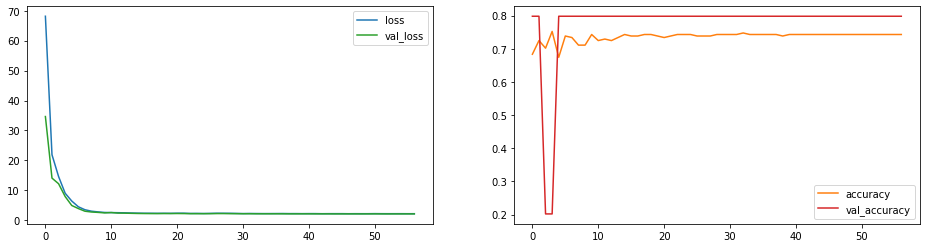

In [174]:
pd.DataFrame(hist.history).plot(subplots=[['loss', 'val_loss'], ['accuracy', 'val_accuracy']], layout=(1,2), figsize=(16,4))

model = keras.models.load_model("best_cnn.h5")

model_accuracy, model_recall, model_precision = get_metrics(model, x_MRI_test, y_MRI_test)


4/4 [==============================] - 4s 992ms/step


<Figure size 432x288 with 0 Axes>

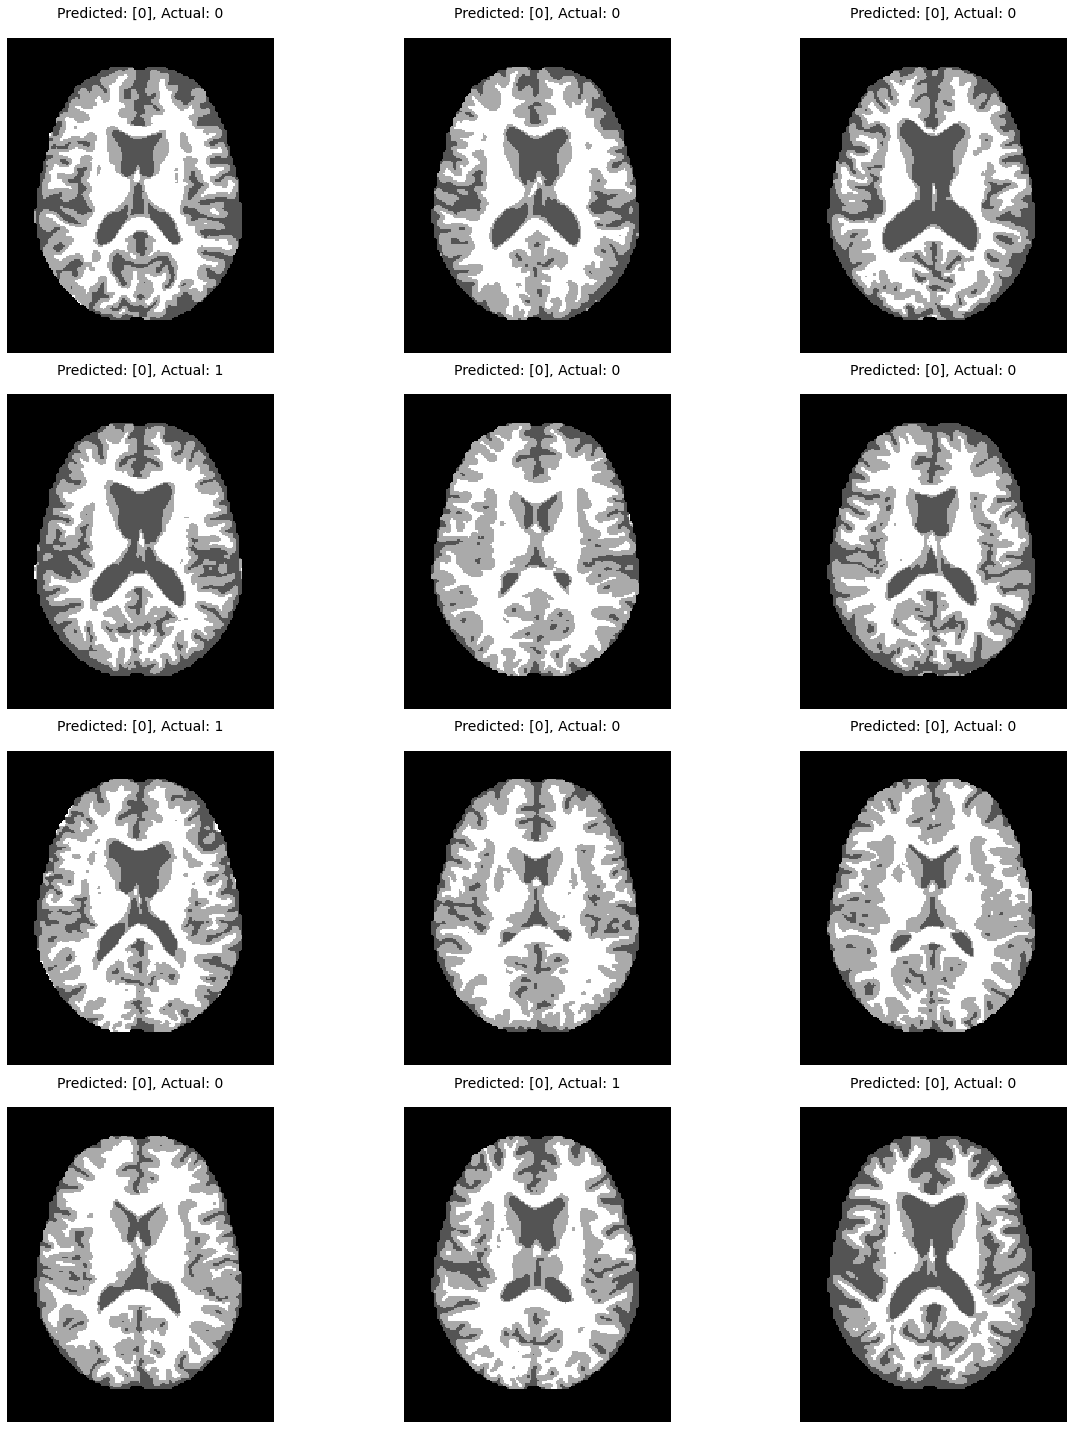

In [157]:


def draw(subject, predictions, ground_truth):
    plt.gray()
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(12):
        ax = fig.add_subplot(4, 3, i+1)
        title = f"Predicted: {predictions[i]}, Actual: {ground_truth[i]}"
        ax.set_title(title, fontsize=14, pad=20)
        ax.matshow(subject[i].reshape((208, 176)).astype(float))
        plt.tight_layout()
        plt.axis('off')
    plt.show()


    
test_predictions = model.predict(x_MRI_test)
test_predictions = (test_predictions > 0.5).astype(int)
draw(x_MRI_test, test_predictions, y_MRI_test)


In [14]:

# tsne = TSNE(n_components=2, init='pca', random_state=42) # initialize t-SNE
# assert x_MRI.shape == (666, 208, 176) # check shape
# x_tsne = tsne.fit_transform(x_MRI.reshape((666,208*176))) # fit data

tsne = TSNE(n_components=2, init='pca', random_state=42) # initialize t-SNE
x_tsne = tsne.fit_transform(x_MRI.reshape((436, 208 * 176))) # fit data


C:\Users\Tanuja\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tanuja\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Epoch 1/600


C:\Users\Tanuja\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 1s 20ms/step - loss: 3.0292 - accuracy: 0.7378 - val_loss: 1.7888 - val_accuracy: 0.8889
Epoch 2/600
8/8 [==============================] - 0s 8ms/step - loss: 1.5189 - accuracy: 0.7514 - val_loss: 0.8519 - val_accuracy: 0.8889
Epoch 3/600
8/8 [==============================] - 0s 8ms/step - loss: 0.9620 - accuracy: 0.7514 - val_loss: 0.7468 - val_accuracy: 0.8889
Epoch 4/600
8/8 [==============================] - 0s 8ms/step - loss: 0.8490 - accuracy: 0.7595 - val_loss: 0.5846 - val_accuracy: 0.8889
Epoch 5/600
8/8 [==============================] - 0s 9ms/step - loss: 0.7277 - accuracy: 0.7541 - val_loss: 0.5285 - val_accuracy: 0.8889
Epoch 6/600
8/8 [==============================] - 0s 8ms/step - loss: 0.6657 - accuracy: 0.7514 - val_loss: 0.5025 - val_accuracy: 0.8889
Epoch 7/600
8/8 [==============================] - 0s 9ms/step - loss: 0.6457 - accuracy: 0.7541 - val_loss: 0.4884 - val_accuracy: 0.8889
Epoch 8/600
8/8 [=====================

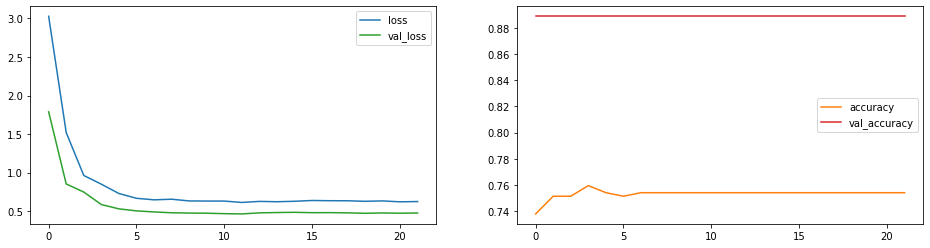

In [152]:
x_tsne_train, x_tsne_temp, y_tsne_train, y_tsne_temp = train_test_split(x_tsne, y_MRI, train_size=0.85, random_state = 42)

x_tsne_val, x_tsne_test, y_tsne_val, y_tsne_test = train_test_split(x_tsne_temp, y_tsne_temp, train_size=0.55, random_state=42)



he = keras.initializers.he_normal(seed=42) 

model_tsne = Sequential([

    Dense(100, input_shape=(2,), kernel_initializer=he),
    Activation('relu'),
    Dense(30, kernel_regularizer=l1(0.01)),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(30),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(15),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(15),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(15),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid'),
])

early_stopping = EarlyStopping(monitor='loss', patience=10)
model_checkpoint = ModelCheckpoint('best_tsne.h5', monitor='loss', save_best_only=True)

optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
model_tsne.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


hist = model_tsne.fit(x_tsne_train, y_tsne_train, batch_size=50, epochs=600, 
                 validation_data=(x_tsne_val, y_tsne_val), callbacks=[early_stopping, model_checkpoint])

pd.DataFrame(hist.history).plot(subplots=[['loss', 'val_loss'], ['accuracy', 'val_accuracy']], layout=(1,2), figsize=(16,4))

model_tsne = keras.models.load_model("best_tsne.h5")



In [175]:
tsne_accuracy, tsne_recall, tsne_precision = get_metrics(model_tsne, x_tsne_test, y_tsne_test)


1/1 [==============================] - 0s 15ms/step


<Figure size 432x288 with 0 Axes>

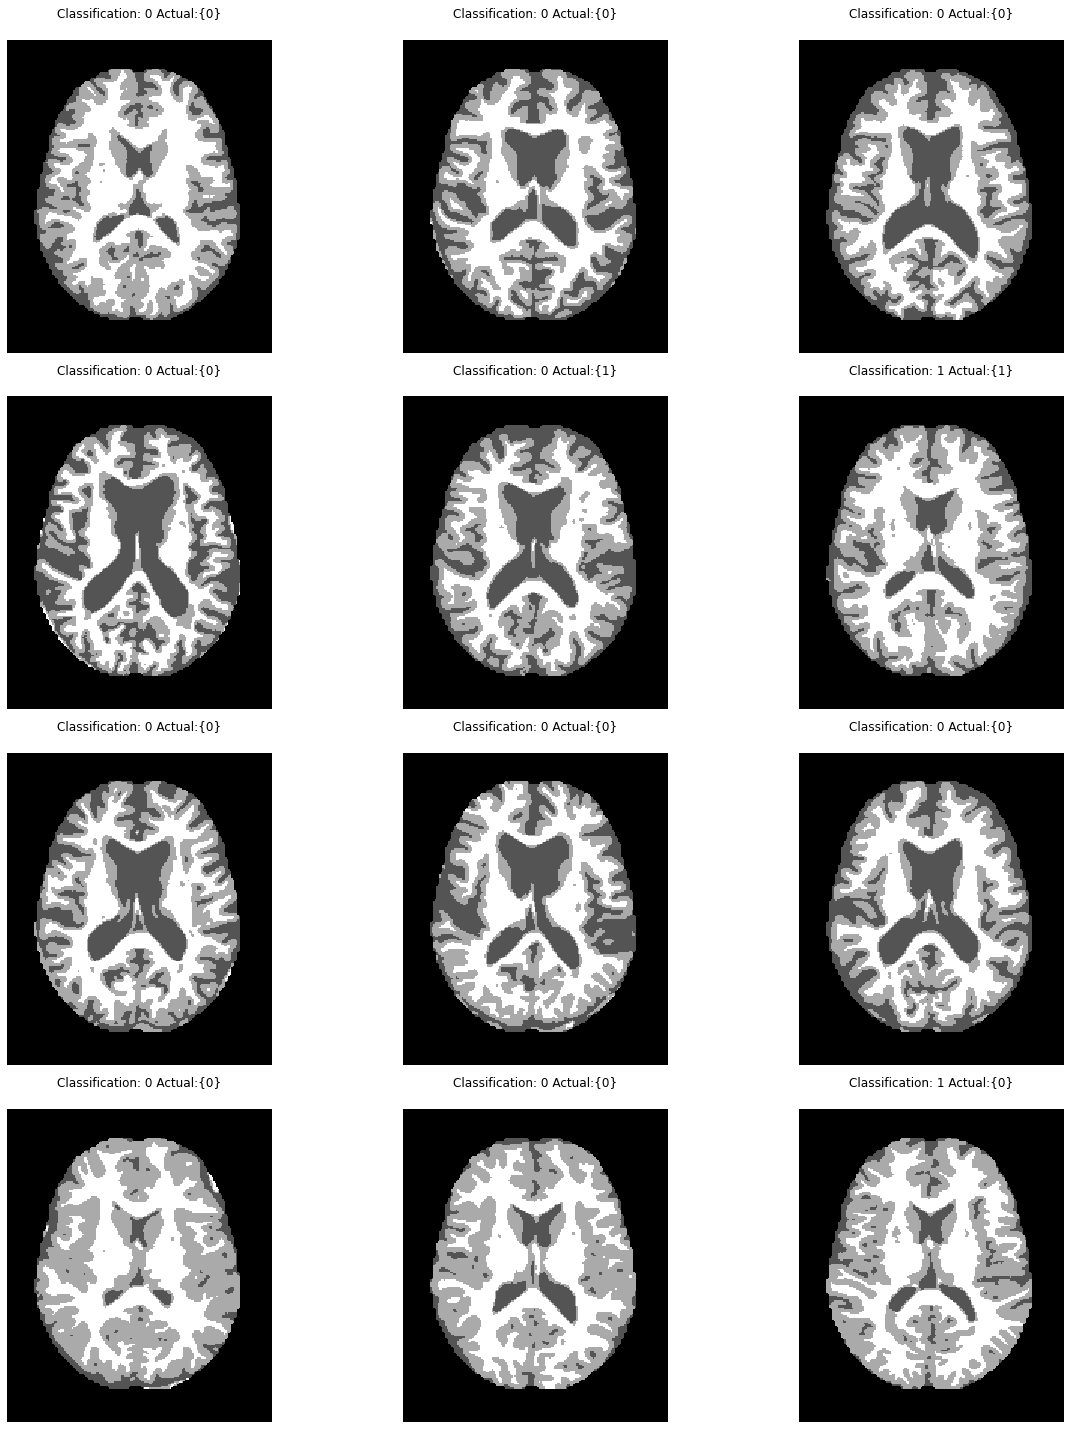

In [17]:
x = x_MRI.reshape((436, 208 * 176))
feat_cols = ['pixel'+str(i) for i in range(x.shape[1])] # name each column a pixel number
df = pd.DataFrame(x, columns=feat_cols) # convert X to dataframe
df['label'] = y_MRI
df['label'] = df['label'].apply(lambda i: str(i)) 
rndperm = np.random.permutation(df.shape[0])


def draw(subject,actual):
    
    plt.gray()
    fig = plt.figure(figsize = (20,20))
    for i in range(0,12):
        ax = fig.add_subplot(4, 3, i+1, title='Classification: ' + str(df.loc[rndperm[i], 'label']) +  ' Actual:' + str({actual[i]}) )
    
        ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((208,176)).astype(float))
        plt.tight_layout()
        plt.axis('off')
    plt.show()

    
draw(x_tsne_test,y_tsne_test)



In [105]:
from keras.regularizers import l1, l2


Epoch 1/500


C:\Users\Tanuja\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 1s 22ms/step - loss: 3.3885 - accuracy: 0.3054 - val_loss: 2.0693 - val_accuracy: 0.1379
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 1.6139 - accuracy: 0.4946 - val_loss: 0.9364 - val_accuracy: 0.8621
Epoch 3/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9482 - accuracy: 0.7297 - val_loss: 0.7584 - val_accuracy: 0.8621
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 0.8583 - accuracy: 0.7459 - val_loss: 0.5787 - val_accuracy: 0.8621
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 0.7391 - accuracy: 0.7486 - val_loss: 0.5286 - val_accuracy: 0.8621
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6750 - accuracy: 0.7486 - val_loss: 0.4992 - val_accuracy: 0.8621
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6522 - accuracy: 0.7486 - val_loss: 0.4901 - val_accuracy: 0.8621
Epoch 8/500
8/8 [====================

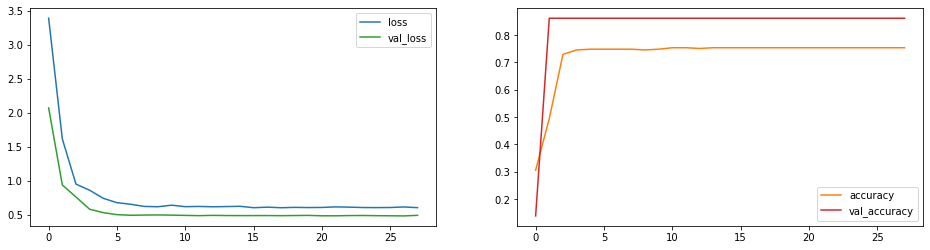

In [143]:
m_PCA = PCA(n_components=10)
m_PCA.fit(x) # fit data with PCA algorithm
xt = m_PCA.transform(x)
xback = m_PCA.inverse_transform(xt)
assert x.shape == xback.shape
xback = xback.reshape((436, 208 * 176))


X_PCA_train,  X_PCA_temp, y_PCA_train, y_PCA_temp = train_test_split(xt, y_MRI, train_size=0.85, random_state = 42)

X_PCA_val, X_PCA_test, y_PCA_val, y_PCA_test = train_test_split(X_PCA_temp, y_PCA_temp, train_size=0.45, random_state=42)

he = keras.initializers.he_normal(seed=42)    

model_PCA = Sequential([
    Dense(100, input_shape=(10,), kernel_initializer=he),
    Activation('relu'),
    Dense(30, kernel_regularizer=l1(0.01)),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(30),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(15),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(15),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(15),
    Activation('sigmoid'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
early_stopping = EarlyStopping(monitor='loss', patience=10)
model_checkpoint = ModelCheckpoint('best_pca.h5', monitor='loss', save_best_only=True)

model_PCA.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
hist = model_PCA.fit(X_PCA_train,y_PCA_train,epochs=500, batch_size=50,  validation_data=(X_PCA_val, y_PCA_val), 
              callbacks=[early_stopping, model_checkpoint])

pd.DataFrame(hist.history).plot(subplots=[['loss', 'val_loss'], ['accuracy', 'val_accuracy']], layout=(1,2), figsize=(16,4))

model_PCA = keras.models.load_model("best_pca.h5")

In [176]:
pca_accuracy, pca_recall, pca_precision = get_metrics(model_PCA, X_PCA_test, y_PCA_test)


2/2 [==============================] - 0s 2ms/step


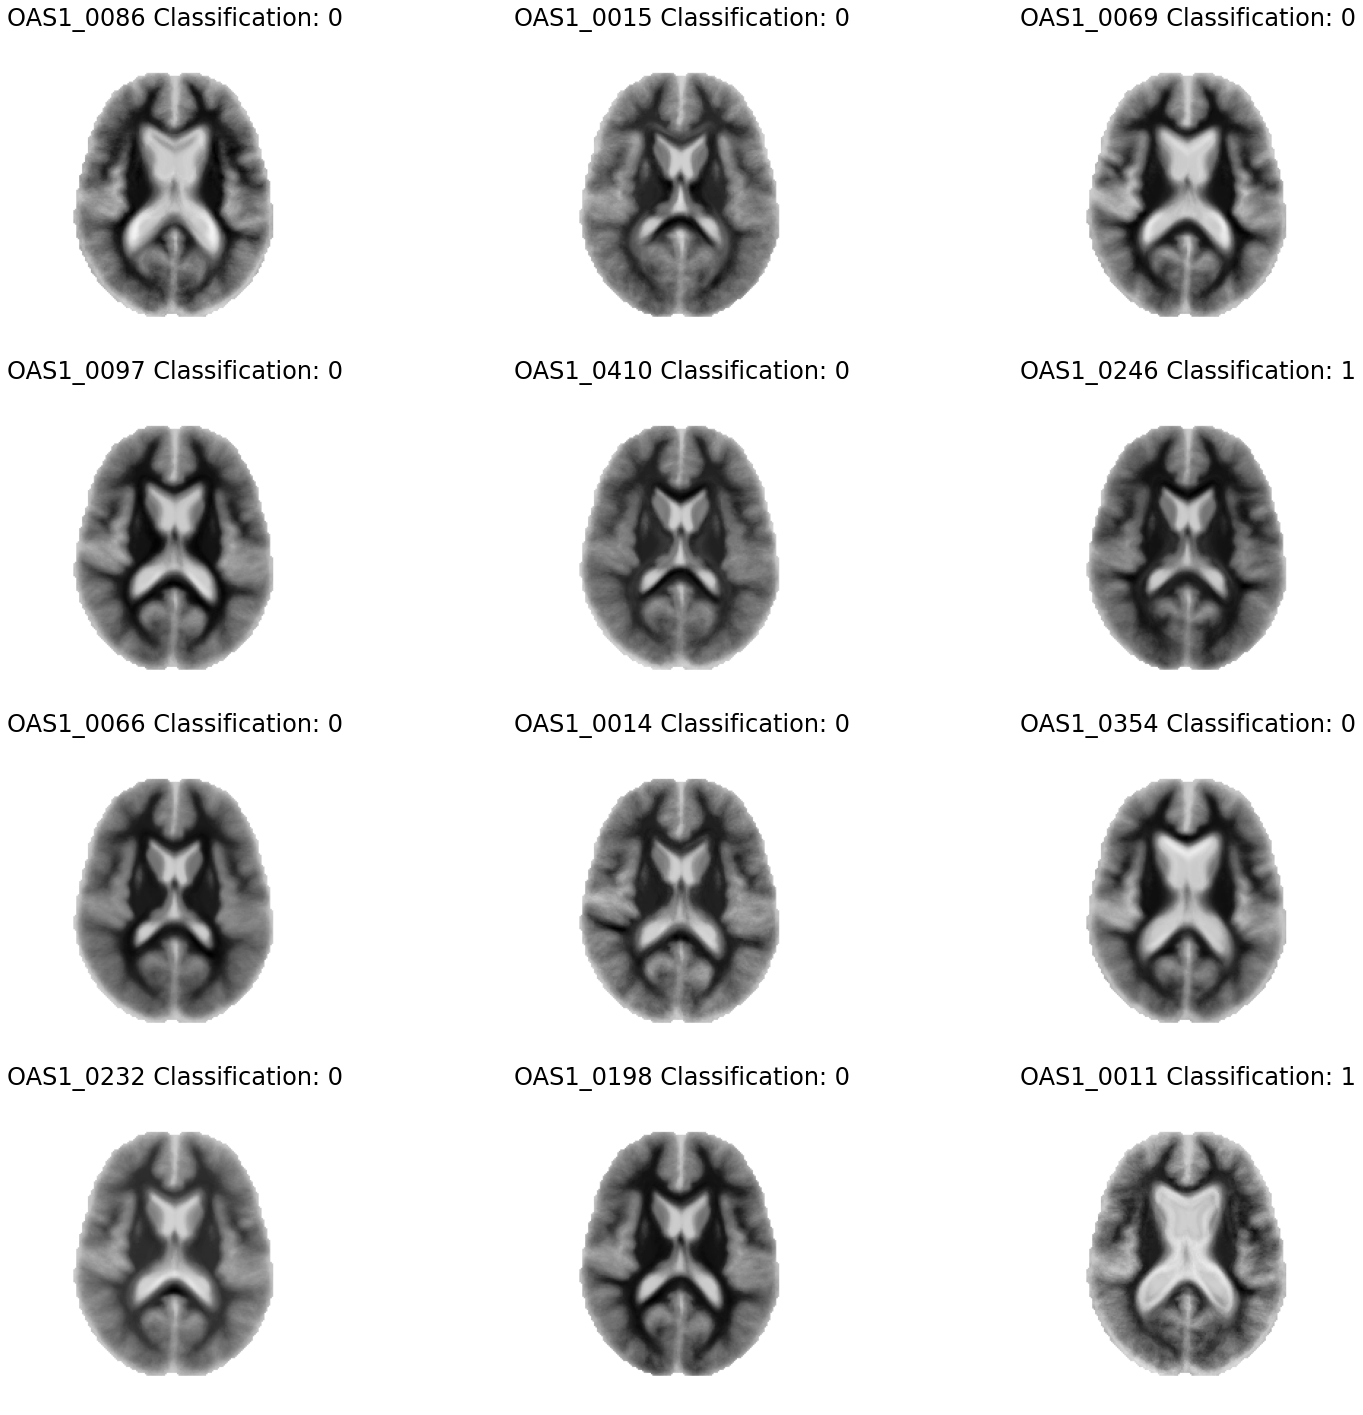

In [145]:
def draw(subject, input, actual):
    plt.figure(figsize=(20,20))
    plt.gray()
    for i in range(0,12):
        plt.subplot(4, 3, i+1)
        plt.title(str(subject[i]) + ' Classification: ' + str(df.loc[rndperm[i],'label']), fontsize=24, pad = 20)
        input_reshaped = input[i].reshape((208, 176))
        
        plt.imshow(input_reshaped, cmap=plt.cm.Greys)
        plt.tight_layout()
        plt.axis('off')
        plt.subplots_adjust(wspace=0.25)

    plt.show()
    
    
draw(shuffled_subjects, xback, y_PCA_test)

In [177]:
result_df = pd.DataFrame({
    'Model': ['CNN','T-SNE + NN','PCA + NN'],
    'Accuracy': [model_accuracy,tsne_accuracy,pca_accuracy],
    'Precision': [model_precision,tsne_precision,pca_precision],
    'Recall': [model_recall,tsne_recall,pca_recall]
 })
result_df = result_df.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Accuracy,Precision,Recall
Model,,,
PCA + NN,86.49,100.0,0.0
T-SNE + NN,83.33,100.0,0.0
CNN,79.82,100.0,0.0


In [159]:
model = keras.models.load_model("best_cnn.h5")

In [164]:
model.summary()
# keras.utils.plot_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 204, 172, 96)      2496      
                                                                 
 batch_normalization_4 (Batc  (None, 204, 172, 96)     384       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 204, 172, 96)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 102, 86, 96)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 98, 82, 160)       384160    
                                                                 
 batch_normalization_5 (Batc  (None, 98, 82, 160)     